In [2]:
import pickle
from scipy.sparse import csr_matrix
from clustering import visualize_silhouette_clusters, compare_true_labels
import numpy as np
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from soyclustering import SphericalKMeans, visualize_pairwise_distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# load the itemset_features variable - i created it in the Wikipedia_Mining notebook
with open('data/breadbasket/minsupp_0.01/itemset_features.pkl', 'rb') as f:
    itemset_features = pickle.load(f)
    
with open('data/breadbasket_time.pkl', 'rb') as f:
    true_labels = pickle.load(f)
    
print("num of groundtruth labels:", len(np.unique(true_labels)))

num of groundtruth labels: 8


In [3]:
# adjust number of clusters
my_num_clusters = 8

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
itemset_matrix = csr_matrix(itemset_features.astype(int))
density = itemset_matrix.getnnz() / np.prod(itemset_matrix.shape)
print("density of matrix:", density)

spherical_kmeans = SphericalKMeans(
        n_clusters=my_num_clusters,
        max_iter=25,
        verbose=1,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

sphkmeans_cluster_labels = spherical_kmeans.fit_predict(itemset_matrix)
print('finished spherical clustering')

density of matrix: 0.03354911493728008
initialization_time=0.004008 sec, sparsity=0.0275
n_iter=1, changed=6486, inertia=5173.927, iter_time=0.025 sec, sparsity=0.555
n_iter=2, changed=605, inertia=3530.240, iter_time=0.028 sec, sparsity=0.564
n_iter=3, changed=433, inertia=3421.641, iter_time=0.025 sec, sparsity=0.572
n_iter=4, changed=176, inertia=3369.434, iter_time=0.017 sec, sparsity=0.561
n_iter=5, changed=15, inertia=3362.425, iter_time=0.013 sec, sparsity=0.564
n_iter=6, changed=57, inertia=3361.917, iter_time=0.014 sec, sparsity=0.559
n_iter=7, changed=71, inertia=3358.016, iter_time=0.016 sec, sparsity=0.553
n_iter=8, changed=14, inertia=3350.160, iter_time=0.019 sec, sparsity=0.553
n_iter=9, changed=13, inertia=3349.330, iter_time=0.015 sec, sparsity=0.551
n_iter=10, changed=1, inertia=3348.503, iter_time=0.019 sec, sparsity=0.547
Early converged.
finished spherical clustering


In [4]:
compare_true_labels(true_labels, sphkmeans_cluster_labels, itemset_features)

Adjusted Rand Index: 0.004808132517747091
Normalized Mutual Information: 0.013910121463070252
Homogeneity: 0.015136070188307598
Completeness: 0.012867884819435117
V-Measure: 0.013910121463070252
Silhouette Score: 0.3849159366396119


In [5]:
# KModes clustering

km = KModes(n_clusters=my_num_clusters, init='Huang', n_init=5, verbose=1, n_jobs=-1)
kmodes_cluster_labels = km.fit_predict(itemset_features)

compare_true_labels(true_labels, kmodes_cluster_labels, itemset_features)

Best run was number 2
Adjusted Rand Index: 0.006726444636584749
Normalized Mutual Information: 0.012627331812976917
Homogeneity: 0.014204328666294773
Completeness: 0.01136550735405442
V-Measure: 0.012627331812976919
Silhouette Score: 0.3118514319229383


In [8]:
# Agglomerative clustering

distances = cosine_distances(itemset_features)

agglo_clustering = AgglomerativeClustering(n_clusters=my_num_clusters, metric="precomputed", linkage="average")
agglo_labels = agglo_clustering.fit_predict(distances)

compare_true_labels(true_labels, agglo_labels, itemset_features)

Adjusted Rand Index: 0.006285879936011162
Normalized Mutual Information: 0.019423547802907698
Homogeneity: 0.011199112264339582
Completeness: 0.07312609485661527
V-Measure: 0.0194235478029077
Silhouette Score: 0.12239246278921562


For n_clusters = 8 The average silhouette_score is : 0.4463738337915542


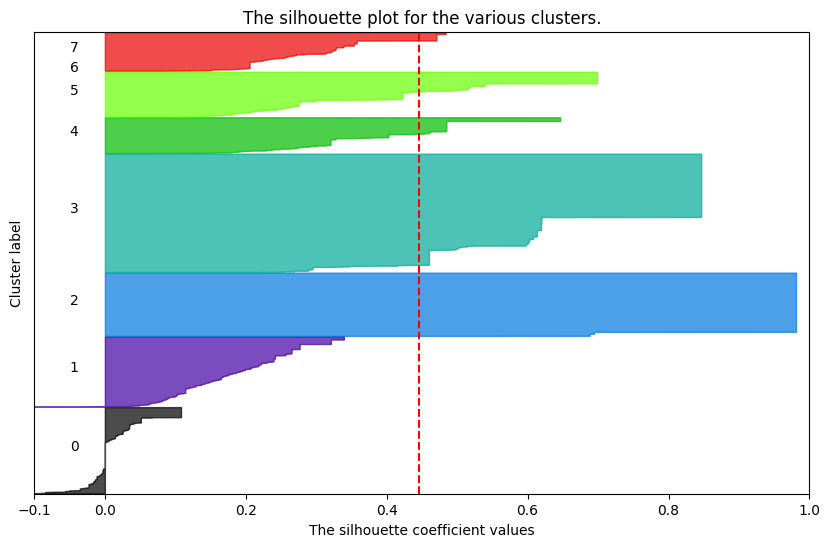

In [5]:
## Silhouette plot to visualize how good clusters are: if they are good, should see more on the right side
## Good average silhouette score apparently should be >0.5?

# Subsample before trying to do silhouette visualization, IF dataset is too big
subsample = False
if subsample:
    subsample_size = 10000  # Adjust as needed

    # Generate random indices for subsampling
    random_indices = np.random.choice(len(itemset_features), subsample_size, replace=False)

    subsample_itemset_features = itemset_features[random_indices]
    subsample_sphkmeans_cluster_labels = sphkmeans_cluster_labels[random_indices]
    visualize_silhouette_clusters(subsample_sphkmeans_cluster_labels, subsample_itemset_features, metric='cosine')
else:
    visualize_silhouette_clusters(sphkmeans_cluster_labels, itemset_features, metric='cosine')

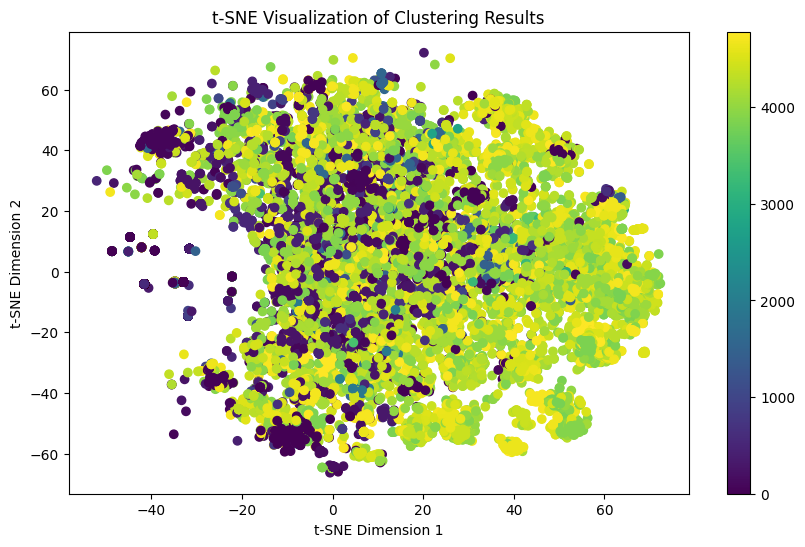

In [4]:
## using t-sne (alternative to pca) to visualize

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(subsample_itemset_features) if subsample else cosine_distances(itemset_features)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))

if subsample:
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=subsample_sphkmeans_cluster_labels, cmap='viridis')
else:
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Clustering Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


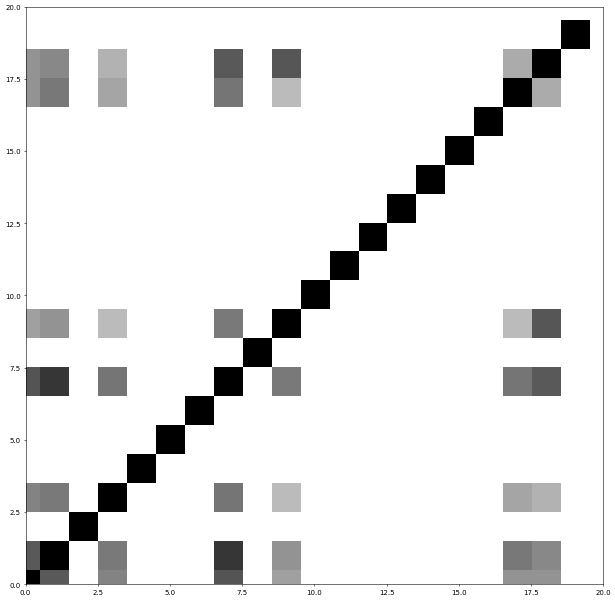

In [5]:
# function included with the sphericalkmeans library to evaluate the distance between the clusters
# dark means closer, light means further away - think ideally should have more light squares?

sphkmeans_centers = spherical_kmeans.cluster_centers_

fig = visualize_pairwise_distance(centers=sphkmeans_centers,
                                  labels=sphkmeans_cluster_labels, 
                                  max_dist=1, 
                                  sort=False)

In [ ]:
# extra

#agglomerative clustering

# from sklearn.metrics.pairwise import cosine_similarity
# Compute the cosine similarity matrix
# similarity = cosine_similarity(itemset_features)
# print(similarity.__sizeof__()/1024)
